# RNAfolding

- [original code](https://github.com/autosome-ru/vigg_ribonanza/blob/main/python_scripts/train_uni_adjnet.py)
- [disucssion](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/discussion/460121)

## Setup

In [ ]:
#| default_exp RNAfolding

In [ ]:
#| export
import torch, math, torch.nn as nn, torch.nn.functional as F
from torch.nn import init
from einops import rearrange
from models.core import *
from models.blocks import *

## Dynamic Positional Bias

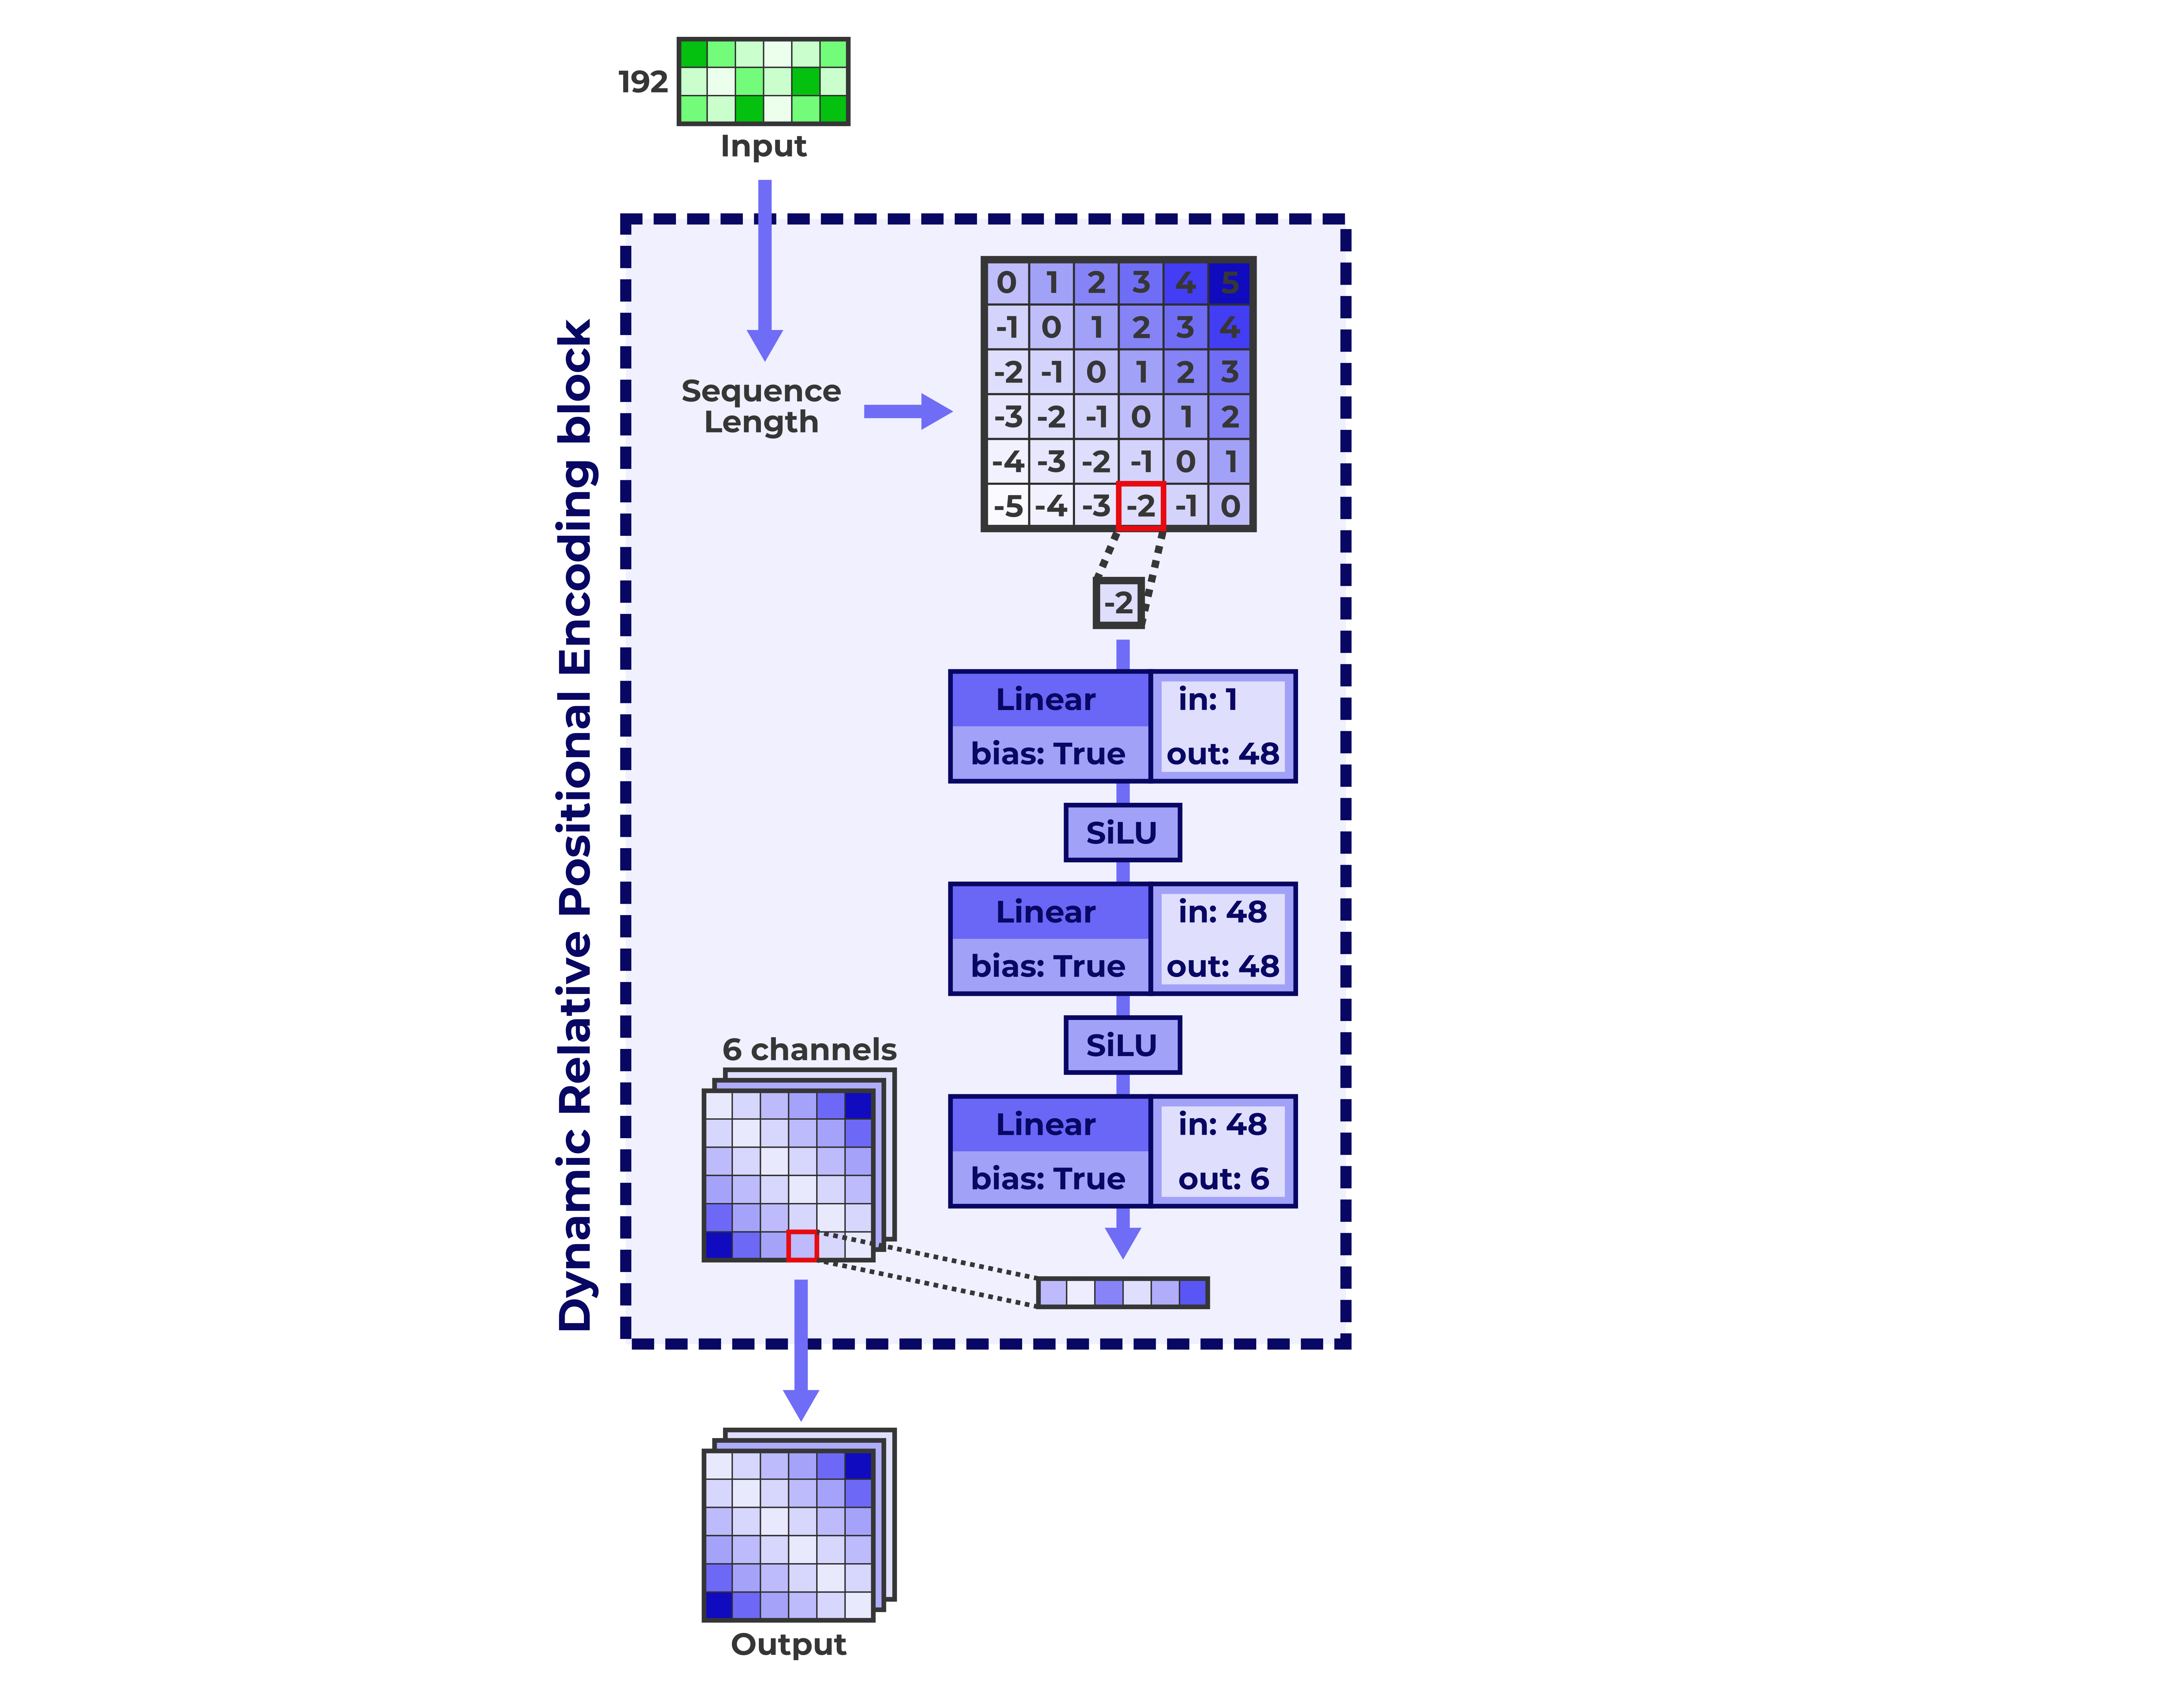

In [ ]:
#| export
class DynamicPos(nn.Module):
    """
    the output of this module will be added to the attention matrix of the transformer;
    set hidden dimension and number of heads; forward with sequence length;
    output has a shape (nheads, seq_len, seq_len)  
    
    """
    def __init__(self, linear_dim, nheads, depth=2):
        super().__init__()

        units = [1] + [linear_dim]*depth
        self.mlp = make_model(lin,units).append(nn.Linear(linear_dim,nheads))

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, inp):
        b,seq_len,h = inp.shape

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(seq_len, device = self.device)
        indices = seq_arange.unsqueeze(-1) - seq_arange.unsqueeze(0)

        # have all number be positive integer
        indices += indices.max()

        # input to continuous positions MLP
        pos = torch.arange(2*seq_len-1,device=self.device).float().unsqueeze(-1) # unsqueeze a dim for mlp
        pos = self.mlp(pos)

        # get position biases
        bias = pos[indices]
        # move the nheads 6 to the front so that it can be added to the attention matrix
        # bias = bias.transpose(0,2).unsqueeze(0)
        bias = rearrange(bias, 'l1 l2 heads -> heads l2 l1')
        return bias

In [ ]:
linear_dim = 100
nheads=6
depth = 2
seq_length=200

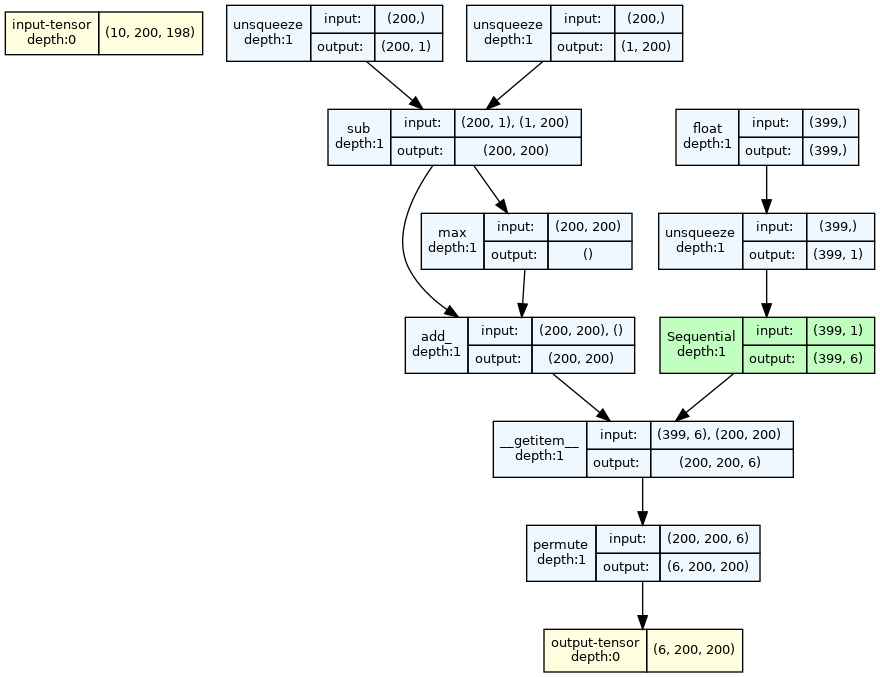

In [ ]:
#| eval: False
plot_model(DynamicPos(linear_dim,nheads,depth),(10,seq_length,198),depth=1)

## Transformer

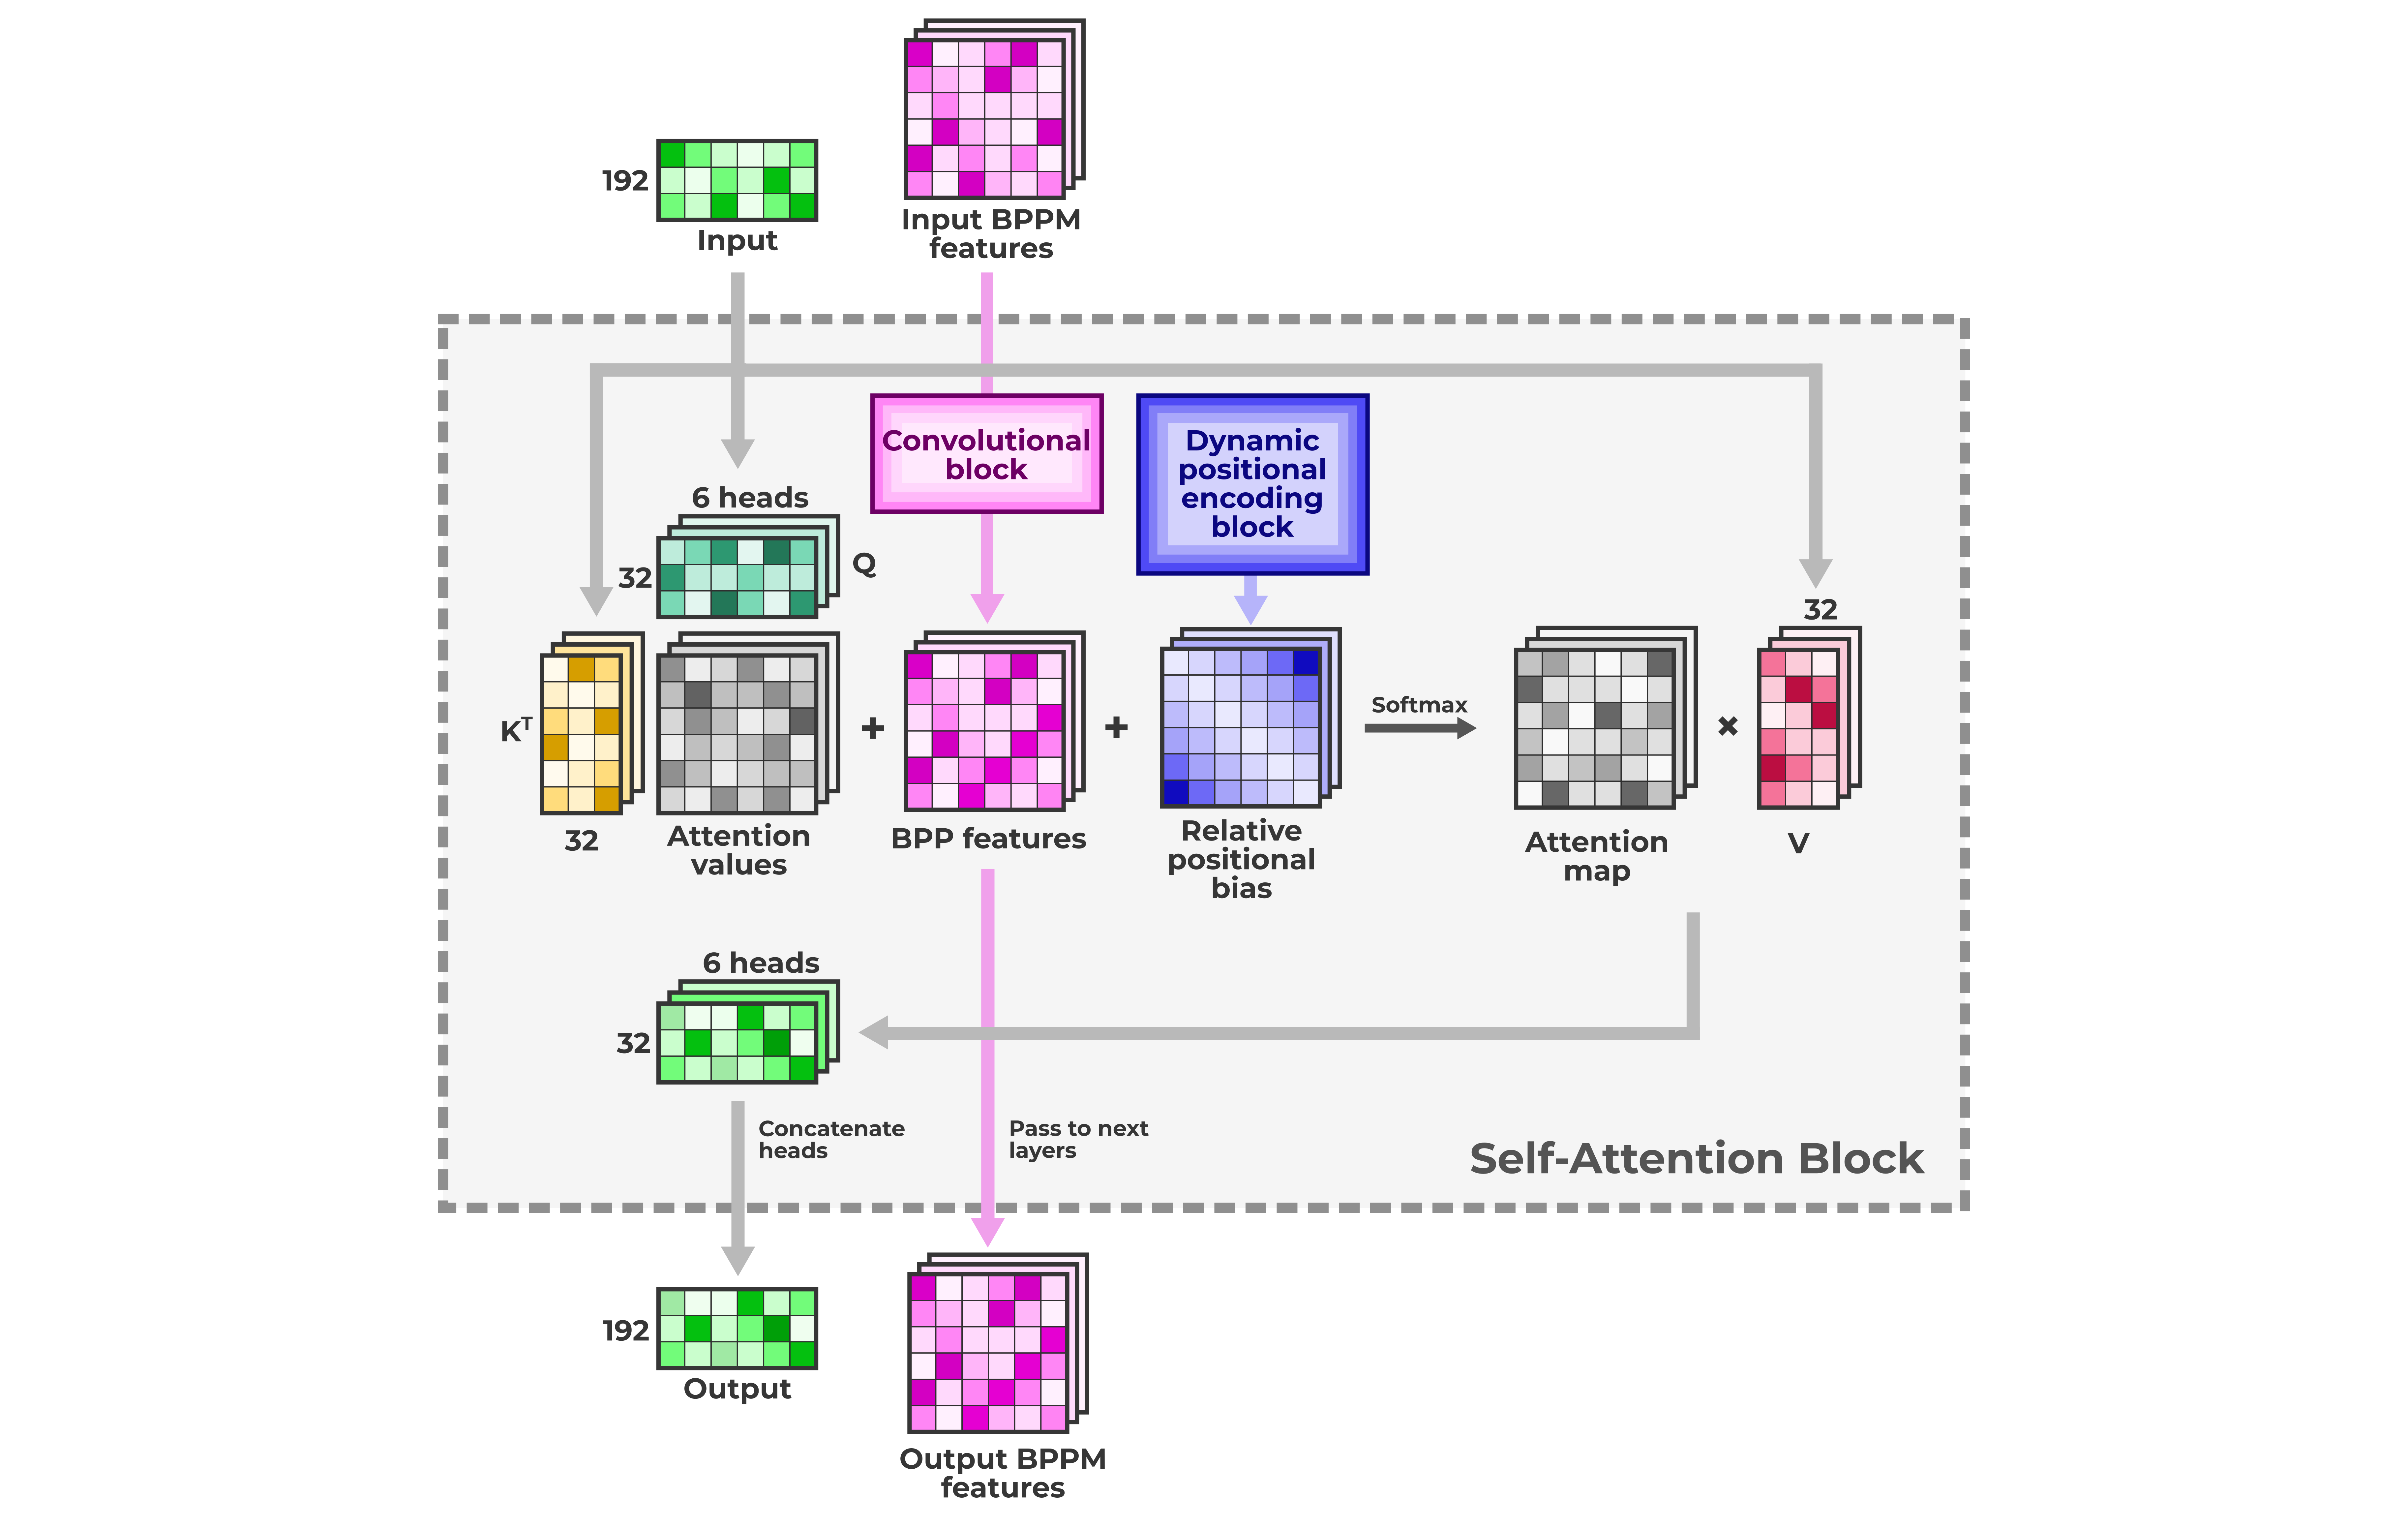

In [ ]:
#| export
class Attn_dynamic(nn.Module):
    
    def __init__(self,
                 embedding_dim,
                 nheads, # embedding_dim should be divisible by nheads
                 dp=0.1):
        super().__init__()

        self.nheads = nheads
        self.attn_chans = embedding_dim//self.nheads
        assert embedding_dim == self.attn_chans*self.nheads, "n embedding is not divisible by nheads"

        self.scale = math.sqrt(embedding_dim/self.nheads)

        self.dynpos = DynamicPos(embedding_dim//4, self.nheads)

        self.norm = nn.LayerNorm(embedding_dim)
        self.qkv = nn.Linear(embedding_dim, embedding_dim*3)

        self.dropout = nn.Dropout(dp)

        # self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.proj = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            lin(embedding_dim,embedding_dim*4, act = nn.GELU,dp=dp),
            lin(embedding_dim*4, embedding_dim,act=None, dp=dp) )


    def forward(self, embedded_seq, bpp=None,mask=None):
        # embedded_seq has a shape of batch, sequence length, and embedding (hidden) dim
        b, l, h = embedded_seq.shape

        # bpp has a shape of h, l, l
        # mask has a shape of b,l

        x = self.norm(embedded_seq) # layer normalize input at the embedding dim

        x = self.qkv(x)
        x = rearrange(x, 'b l (h attn_chans) -> b h l attn_chans', h=self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        attn = (q @ k.transpose(-1,-2))/self.scale # b, h, l, l

        position_matrix = self.dynpos(embedded_seq) # h, l, l


        attn = attn + position_matrix

        if bpp is not None:
            attn = attn + bpp

        attn = attn.softmax(dim = -1)

        if mask is not None:
            attn = attn*mask[:,None,None,:]

        x = attn @ v  # b, a, l, head

        x = rearrange(x, ' b h l attn_chans -> b l (h attn_chans)', h=self.nheads)

        # skip connect dropout attn with embedded_seq
        x = self.dropout(x) + embedded_seq

        # skip connect proj before with after
        x = x+ self.proj(x)

        return x

In [ ]:
embedding_dim = 12
nheads=6
bs = 10
seq_len=200

In [ ]:
m = Attn_dynamic(embedding_dim,nheads)

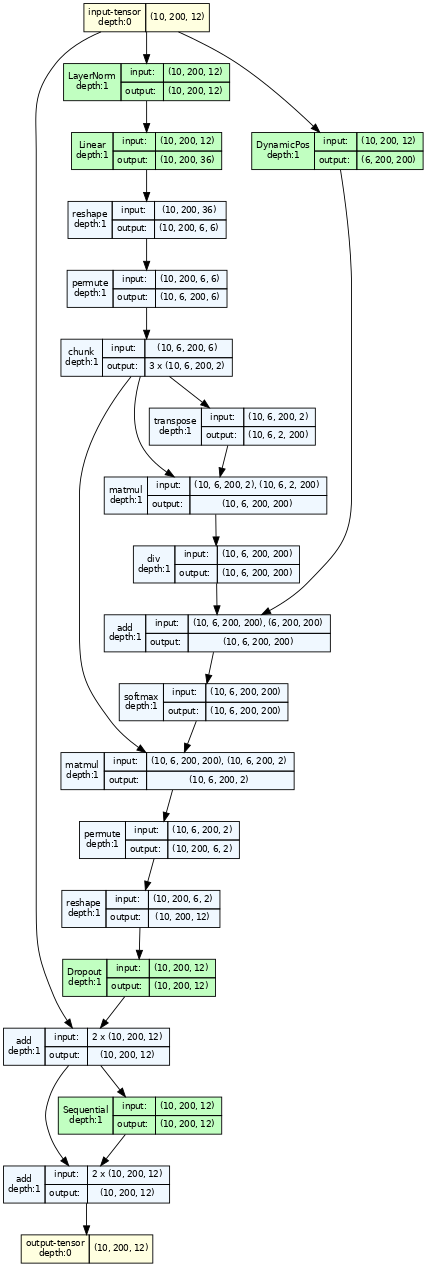

In [ ]:
#| eval: False
plot_model(Attn_dynamic(embedding_dim,nheads),[(bs,seq_len,embedding_dim)],depth=1)

In [ ]:
inp = [
    torch.randn(bs,seq_len,embedding_dim), # seq
       torch.randn(nheads,seq_len,seq_len), # bpp
       torch.randint(0,2,(bs,seq_len)) # mask
       ]

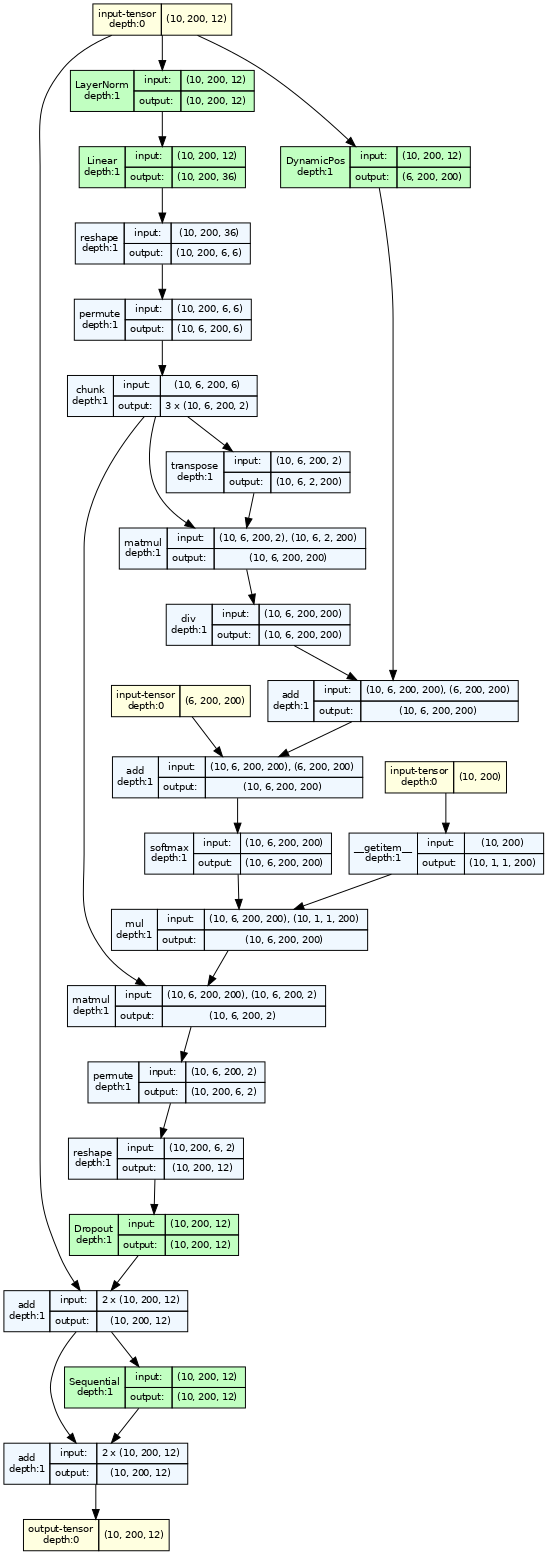

In [ ]:
#| eval: False
plot_model(Attn_dynamic(embedding_dim,nheads),[(bs,seq_len,embedding_dim), # embedded_seq
                                    (nheads,seq_len,seq_len), # bpp_matrix
                                    (bs,seq_len)],depth=1) #mask

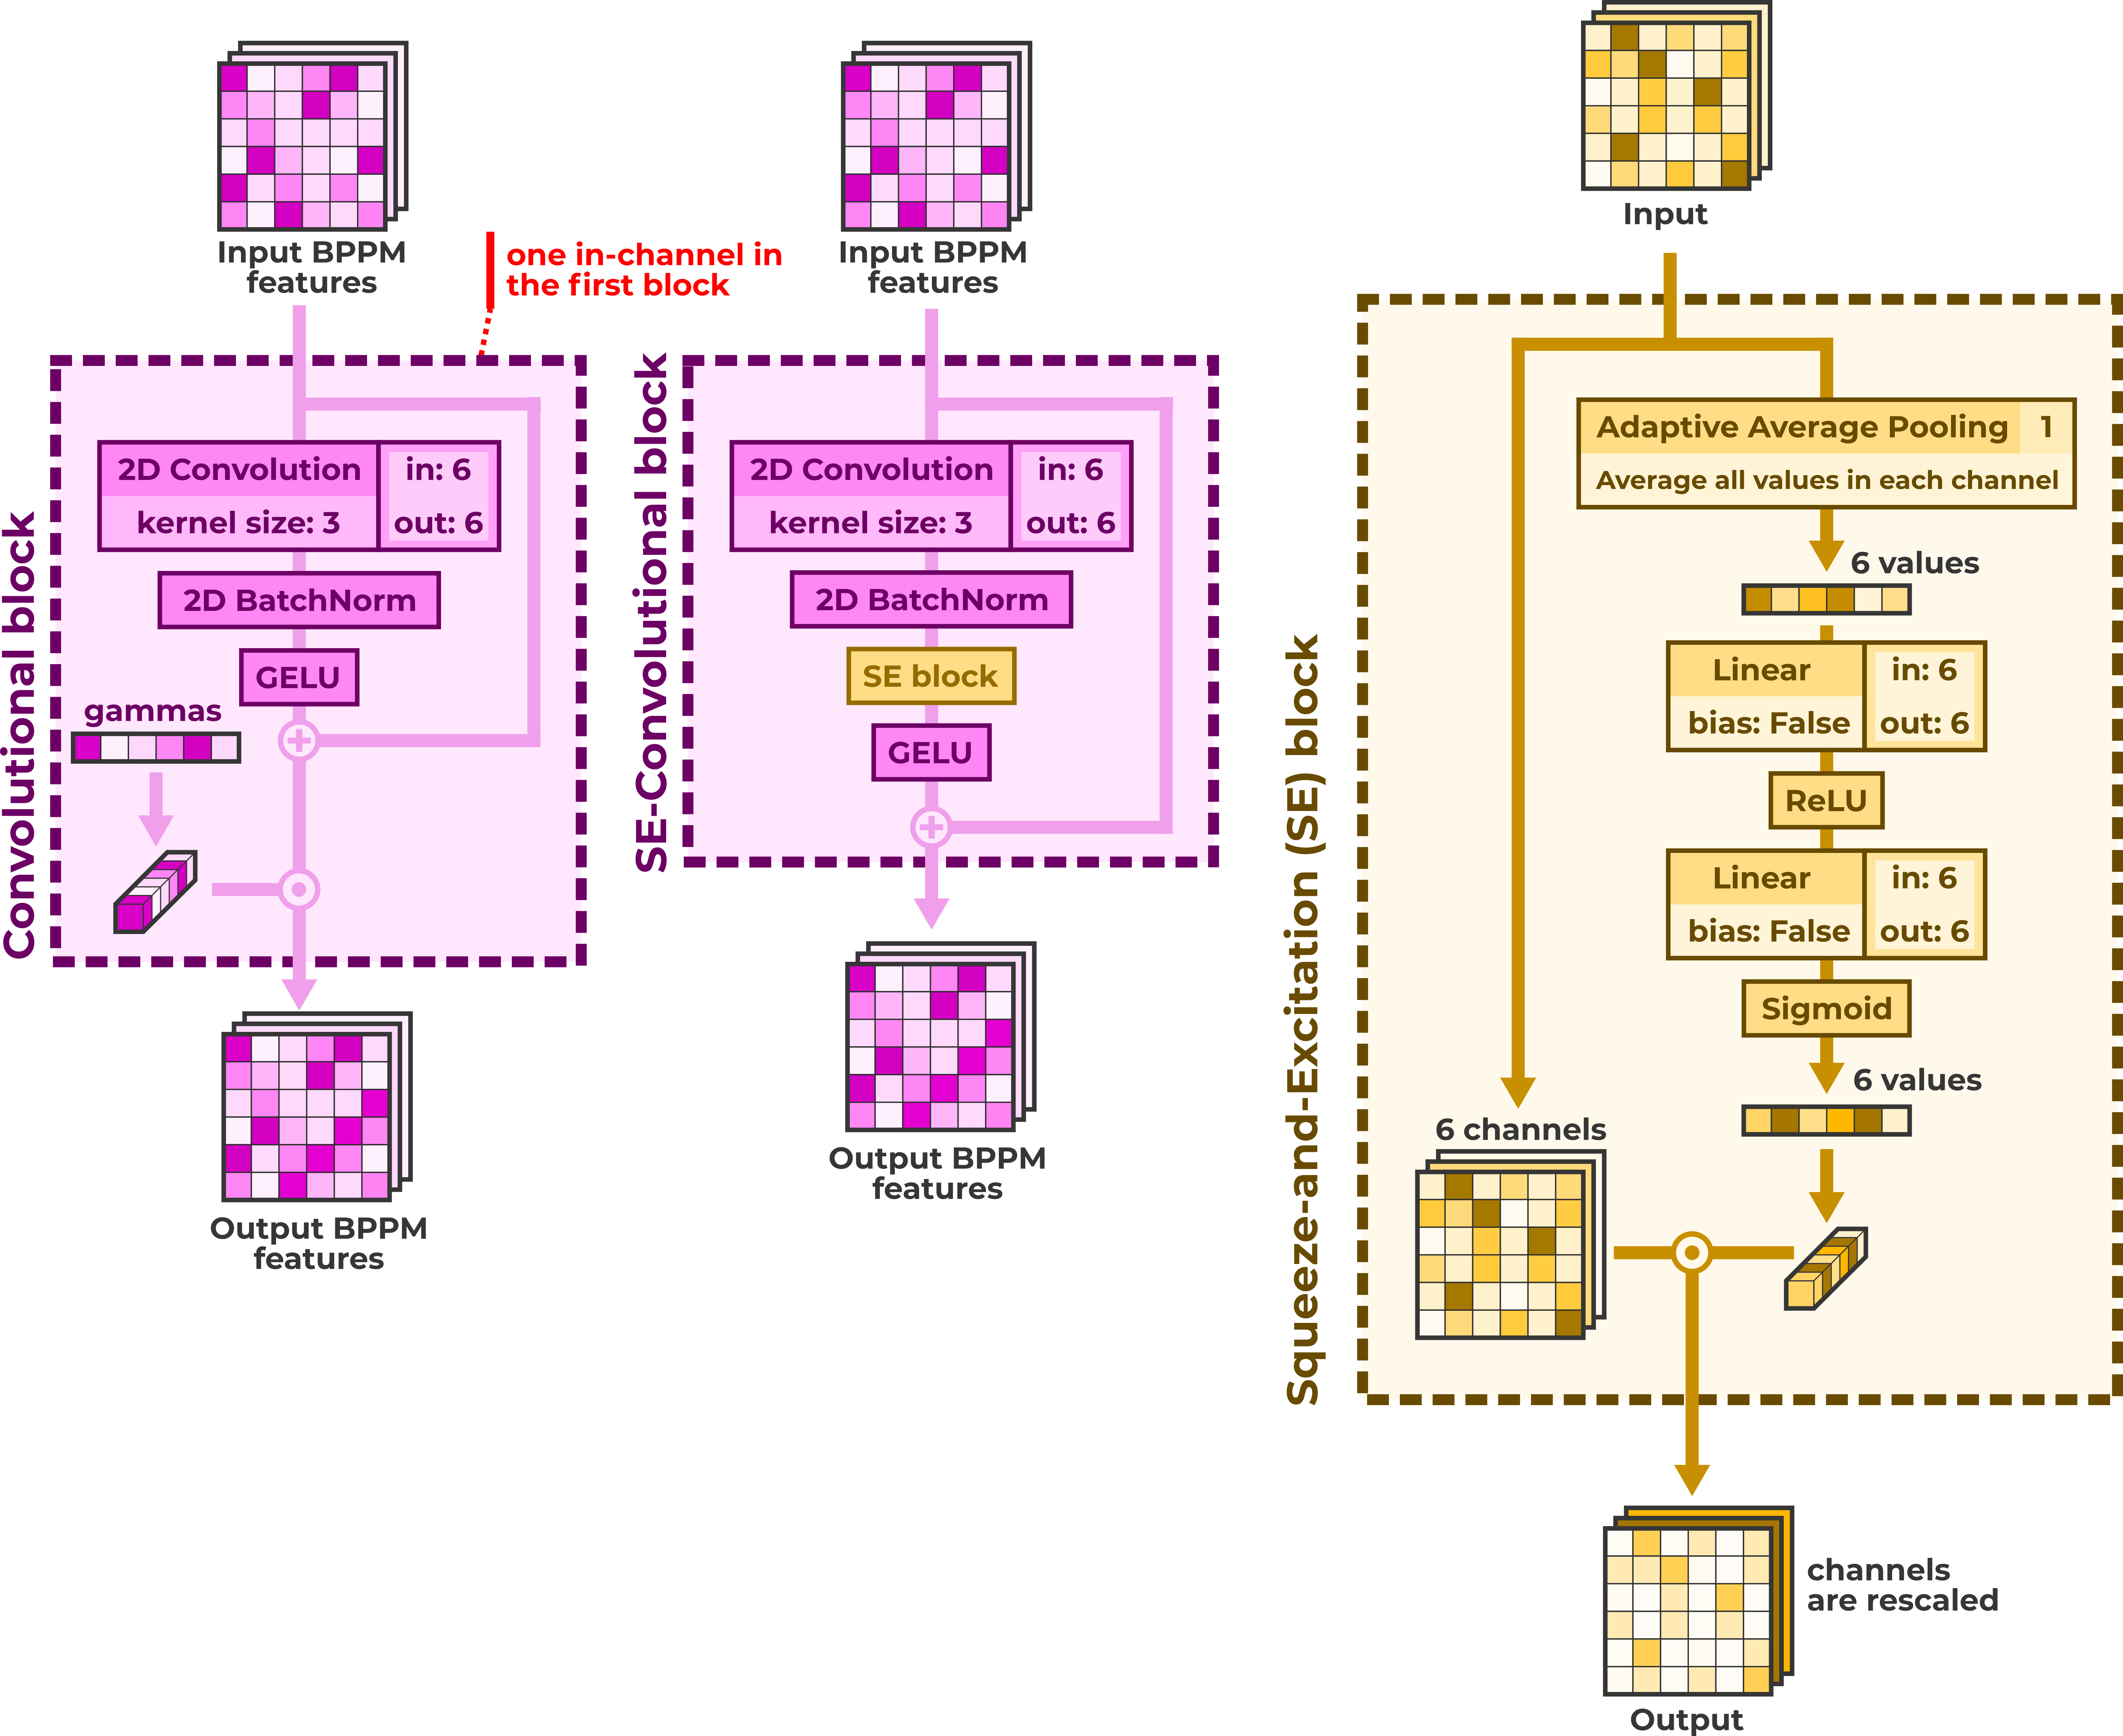

- input: (bs, channel, length, length) ; image/matrix like
- output: (bs, channel, length, length)

In [ ]:
#| export
class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
    def __init__(self, channel, reduction=1):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, l1, l2 = x.shape
        y = self.squeeze(x).squeeze()
        y = self.excitation(y)[:,:,None,None]
        return x * y.expand_as(x)

In [ ]:
channel = 6
scale =2
bs = 10
seq_length = 200

In [ ]:
m = SE_Block(channel,scale)

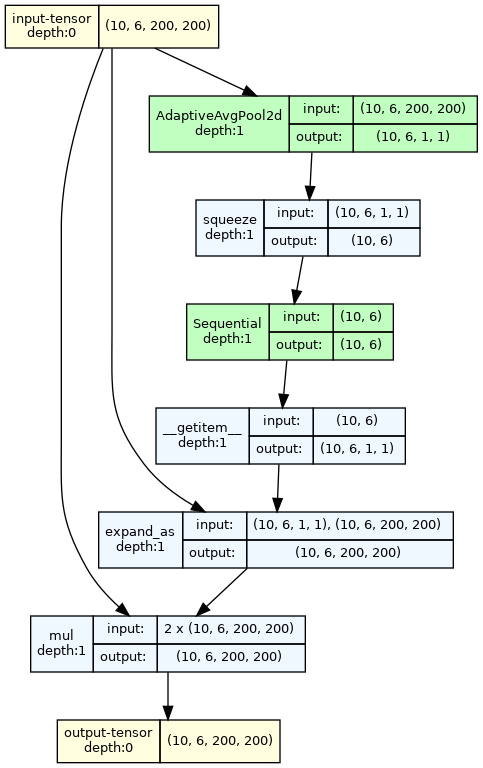

In [ ]:
#| eval: False
plot_model(SE_Block(channel,scale),(bs,channel,seq_length,seq_length),depth=1)

- input: (b, c, l, l)
- output (b, c2, l,l)

In [ ]:
#| export
class ResConv2dSimple(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=7, use_se = False):
        super().__init__()

        if not kernel_size % 2:
            raise ValueError("kernel_size should be an odd number")

        layers = [
            nn.Conv2d(in_c, out_c, kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_c)
        ]

        if use_se:
            layers.append(SE_Block(out_c))

        layers.append(nn.GELU())
        self.conv = nn.Sequential(*layers)

        if in_c == out_c:
            self.res = nn.Identity()
        else:
            self.res = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_c))

    def forward(self, x):
        # b e s
        x = self.res(x) + self.conv(x)
        return x

In [ ]:
m = ResConv2dSimple(1,6, use_se=True)

In [ ]:
m(torch.randn((2,1,100,100))).shape

torch.Size([2, 6, 100, 100])

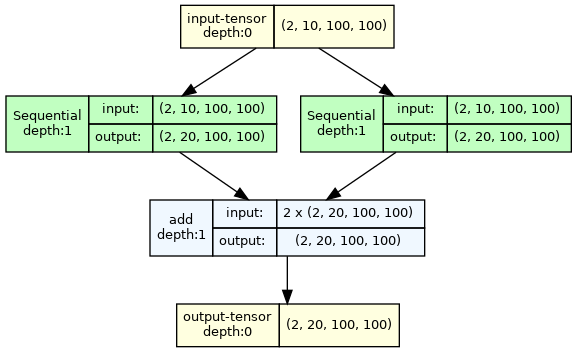

In [ ]:
#| eval: False
plot_model(ResConv2dSimple(10,20, use_se=True),(2,10,100,100),depth=1)

In [ ]:
#| export
class BppTransformerEncoder(nn.Module):
    def __init__(self,
                 ni, # embedding dim
                 nheads,
                 ntransformer=12,
                 nconv=3,
                 ks= 3,
                 use_se = True,
                ):
        super().__init__()

        self.num_heads = nheads

        self.transformers = nn.ModuleList([Attn_dynamic(ni,nheads)]*ntransformer)

        convs = [ResConv2dSimple(in_c=1, out_c=nheads,kernel_size=ks, use_se=use_se)]
        for i in range(nconv-1):
            convs.append(ResConv2dSimple(in_c=nheads, out_c=nheads,kernel_size=ks, use_se=use_se))
        self.convs = nn.ModuleList(convs)


    def forward(self, x, bpp, mask=None):
        # bpp has a shape of bs 1 L L
        for ind, mod in enumerate(self.transformers):
            if ind < len(self.convs):
                conv = self.convs[ind]

                # convert bpp shape to bs heads L L
                bpp = conv(bpp)

            x = mod(x, bpp=bpp,mask=mask)

        return x

In [ ]:
m = BppTransformerEncoder(198,6)

In [ ]:
x,bpp = [torch.randn(10,200,198),
         torch.rand(10,1,200,200)]

In [ ]:
inp = [x,bpp]

In [ ]:
m(*inp).shape

torch.Size([10, 200, 198])

In [ ]:
bpp1 = m.convs[0](bpp)

In [ ]:
bpp2 = m.convs[1](bpp1)

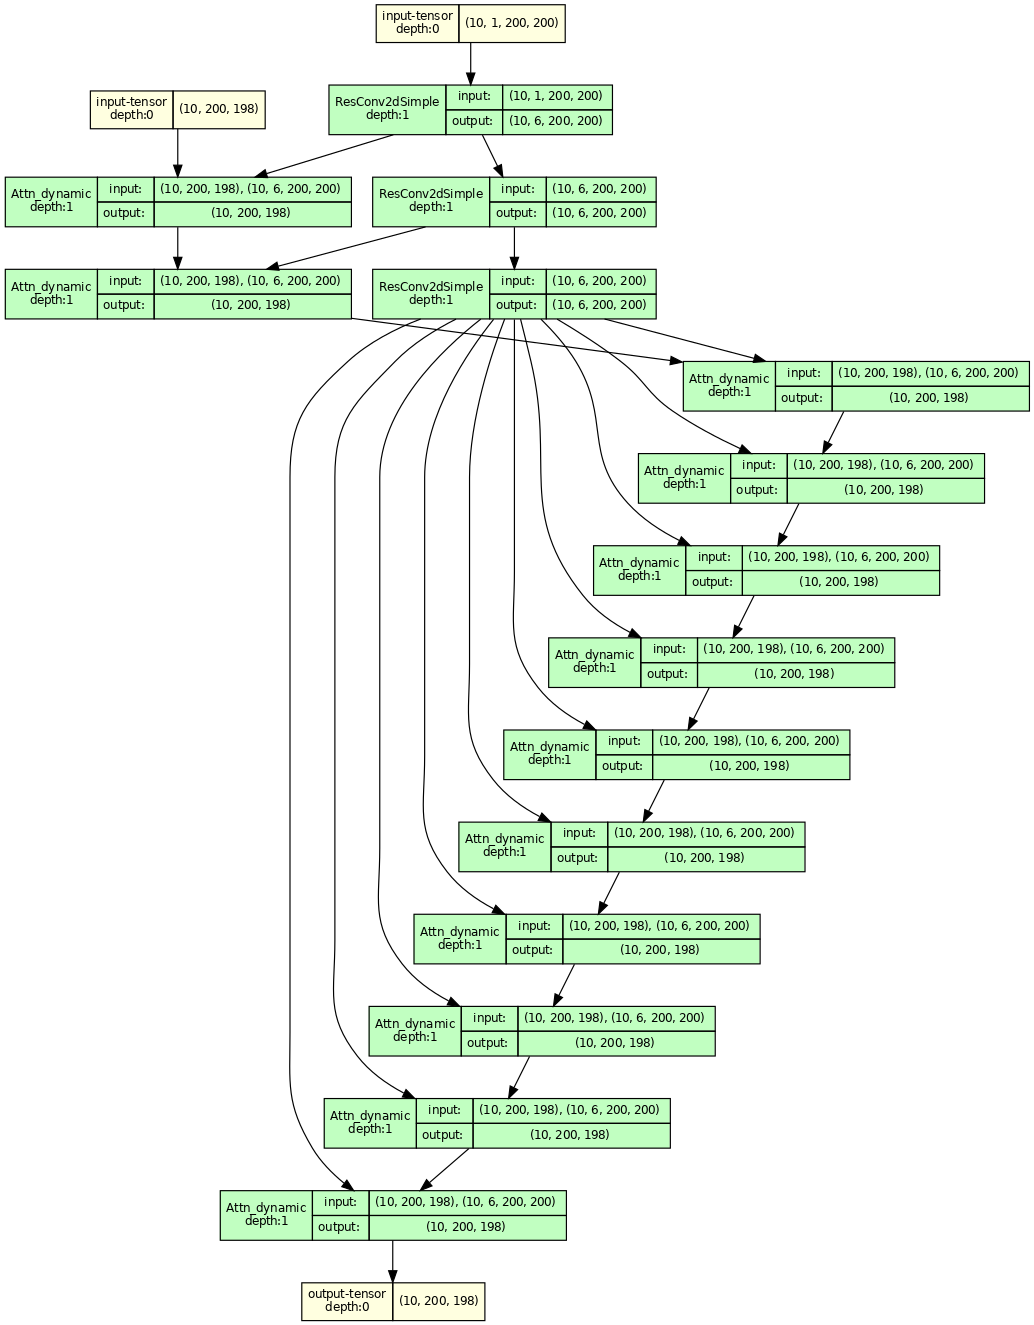

In [ ]:
#| eval: False
plot_model(m, [(10,200,198),(10,1, 200,200)],depth=1)

In [ ]:
# For test purpose
class BppRNAformer2(nn.Module):
    def __init__(self, nembed=192, nheads=6,**kwargs):

        super().__init__()

        self.emb = nn.Embedding(4+3,nembed) # 4 nucleotides + 3 tokens
        self.is_good_embed = nn.Embedding(2, nembed)

        self.transformer = BppTransformerEncoder(ni=nembed, nheads = nheads, **kwargs)

        self.proj = nn.Sequential(nn.Linear(nembed, nembed),
                                      nn.GELU(),
                                      nn.Linear(nembed, 2))


    def forward(self, seq,mask,sn_filter,bpp):

        # mask
        # mask = inp['mask']
        # remove padding tokens to improve performance and accelerate training
        Lmax = mask.sum(-1).max()
        mask = mask[:,:Lmax]

        # bpp = inp['bpp']
        # remove padding tokens
        bpp = bpp[:, :Lmax, :Lmax]

        # As bpp values range from 0 to 1, log transform it
        bpp = torch.log(bpp+1e-5)
        # reshape it so that it can go through the conv layer
        bpp = bpp.unsqueeze(1) # bs 1 L L

        # embed seq
        x = self.emb(seq[:, :Lmax]) # bs seq_length embedding_dim

        # embed sn filter
        e_is_good = self.is_good_embed(sn_filter) # B E

        # combine
        x = x + e_is_good

        x = self.transformer(x, bpp, mask=mask)

        x = self.proj(x)

        return x

In [ ]:
#| export
class BppRNAformer(nn.Module):
    def __init__(self, nembed=192, nheads=6,**kwargs):

        super().__init__()

        self.emb = nn.Embedding(4+3,nembed) # 4 nucleotides + 3 tokens
        self.is_good_embed = nn.Embedding(2, nembed)

        self.transformer = BppTransformerEncoder(ni=nembed, nheads = nheads, **kwargs)

        self.proj = nn.Sequential(nn.Linear(nembed, nembed),
                                      nn.GELU(),
                                      nn.Linear(nembed, 2))


    def forward(self, inp):

        # mask
        mask = inp['mask']
        # remove padding tokens to improve performance and accelerate training
        Lmax = mask.sum(-1).max()
        mask = mask[:,:Lmax]

        bpp = inp['bpp']
        # remove padding tokens
        bpp = bpp[:, :Lmax, :Lmax]

        # As bpp values range from 0 to 1, log transform it
        bpp = torch.log(bpp+1e-5)
        # reshape it so that it can go through the conv layer
        bpp = bpp.unsqueeze(1) # bs 1 L L

        # embed seq
        x = self.emb(inp['seq'][:, :Lmax]) # bs seq_length embedding_dim

        # embed sn filter
        e_is_good = self.is_good_embed(inp['sn_filter']) # bs 1 embedding_dim

        # combine
        x = x + e_is_good

        x = self.transformer(x, bpp, mask=mask)

        x = self.proj(x)

        return x

In [ ]:
inp = {'seq':(10,200),
       'mask':(10,200),
       'sn_filter':(10,1),
       'bpp':(10,200,200)}

In [ ]:
inp2 = [i for i in inp.values()]

In [ ]:
model =BppRNAformer2()

In [ ]:
inp3 = [torch.randint(0,6,inp2[0]),torch.randint(1,2,inp2[1]),torch.randint(0,2,inp2[2]),torch.rand(inp2[3])]

In [ ]:
seq,mask,sn_filter,bpp = [inp3[i] for i in range(len(inp3))]

In [ ]:
model(*inp3).shape

torch.Size([10, 200, 2])

In [ ]:
nembed=192
nheads=6

In [ ]:
emb = nn.Embedding(4+3,nembed)
is_good_embed = nn.Embedding(2, nembed)

In [ ]:
x = emb(seq)

In [ ]:
is_good_embed(sn_filter).shape

torch.Size([10, 1, 192])

In [ ]:
Lmax = mask.sum(-1).max()

In [ ]:
transformer = BppTransformerEncoder(ni=nembed, nheads = nheads)

In [ ]:
#| eval: False
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
from einops import rearrange

df = pd.read_pickle('train_data_1k_bpp.pkl')

df.experiment_type.value_counts()

df['bpp'].values[0].shape

sn = np.array([1.2,3,0.5])

sn = torch.from_numpy(sn)

torch.log(sn + 1.01)

weights = 0.5 * torch.clamp_min(torch.log(sn + 1.01),0.01)

a = RNA_Dataset(df,300)

a[0]

col = df.columns[7:100]

a = df[col].values[0]

a.shape

b= np.stack([a,a],axis=-1)

b.shape

np.pad(b,((1,100),(0,0))).shape

a = df.bpp[0]

torch.from_numpy(a).float()

np.pad(a,(1,100)).shape

class RNA_Dataset(Dataset):
    def __init__(self, df, Lmax):

        self.seq_map = {'A':0,'C':1,'G':2,'U':3, "START": 4, "END": 5, "EMPTY": 6}

        self.Lmax = Lmax

        df['L'] = df.sequence.apply(len)

        df_2A3 = df.loc[df.experiment_type=='2A3_MaP']
        # df_DMS = df.loc[df.experiment_type=='DMS_MaP']

        # self.sid = df_2A3['sequence_id'].values
        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        self.bpp = df_2A3['bpp'].values

        react_col = df.columns[df.columns.str.contains('reactivity_0')]

        self.react_2A3 = df_2A3[react_col].values
        # self.react_DMS = df_DMS[react_col].values


        # self.is_good =  ((df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0) )* 1
        self.is_good =  (df_2A3['SN_filter'].values > 0)* 1 #times1 can convert the array to bool type

        # self.sn_2A3 = df_2A3['SN_filter'].values
        # self.sn_DMS = df_DMS['SN_filter'].values
        sn = df_2A3['SN_filter'].values

        # sn = (df_2A3['signal_to_noise'].values + df_DMS['signal_to_noise'].values) / 2

        sn = torch.from_numpy(sn)

        self.weights = 0.5 * torch.clamp_min(torch.log(sn + 1.01),0.01)


    def __len__(self):
        return len(self.seq)

    def _process_seq(self, rawseq):
        seq = []
        seq.append(self.seq_map['START'])
        start_loc = len(seq) - 1
        seq.extend(self.seq_map[s] for s in rawseq)
        seq.append(self.seq_map['END'])
        end_loc = len(seq) - 1
        for i in range(len(seq), self.Lmax+2):
            seq.append(self.seq_map['EMPTY'])

        seq = np.array(seq)
        seq = torch.from_numpy(seq)

        return seq, start_loc, end_loc

    # def _preprocess_bpp(self,bpp,Lmax):
    #   dif = maxL - bpp.shape[0]
    #   bpp = np.pad(bpp, (0, dif))
    #   return bpp


    def __getitem__(self, idx):
        seq = self.seq[idx]
        real_seq_L = len(seq)

        seq_int, start_loc, end_loc = self._process_seq(seq)

        mask = torch.zeros(self.Lmax + 2, dtype=torch.bool)
        mask[start_loc+1:end_loc] = True # not including START and END

        forward_mask = torch.zeros(self.Lmax + 2, dtype=torch.bool) # START, seq, END
        forward_mask[start_loc:end_loc+1] = True # including START and END


        react = self.react_2A3[idx][:real_seq_L]
        lbord = 1 #for padding, left bord
        rbord = self.Lmax  + 1 - real_seq_L # right bord
        react = np.pad(react, (lbord,rbord), constant_values=np.nan)
        react = torch.from_numpy(react)


        X = {'seq_int': seq_int,
             "forward_mask": forward_mask,
             'is_good': self.is_good[idx]}

        # sid = self.sid[idx]

        bpp = self.bpp[idx]
        # bpp = self._preprocess_bpp(bpp,self.Lmax)
        # adj = load_eterna(sid,  self.Lmax)[:real_seq_L, :real_seq_L]
        #adj = self.eterna_feat[sid][:real_seq_L, :real_seq_L]
        bpp = np.pad(bpp, (lbord,rbord), constant_values=0)
        bpp = torch.from_numpy(bpp).float()


        X['bpp'] = bpp
        y = {'react': react.float(),
             'mask': mask}


        return X, y

class RNA_Dataset(Dataset):
    def __init__(self, df, Lmax):

        self.seq_map = {'A':0,'C':1,'G':2,'U':3, "START": 4, "END": 5, "EMPTY": 6}

        self.Lmax = Lmax

        df['L'] = df.sequence.apply(len)

        df_2A3 = df.loc[df.experiment_type=='2A3_MaP']
        df_DMS = df.loc[df.experiment_type=='DMS_MaP']

        # self.sid = df_2A3['sequence_id'].values
        self.seq = df_2A3['sequence'].values
        self.L = df_2A3['L'].values
        self.bpp = df_2A3['bpp'].values

        react_col = df.columns[df.columns.str.contains('reactivity_0')]

        self.react_2A3 = df_2A3[react_col].values
        self.react_DMS = df_DMS[react_col].values


        # self.is_good =  ((df_2A3['SN_filter'].values > 0) & (df_DMS['SN_filter'].values > 0) )* 1
        self.is_good =  ((df_2A3['SN_filter'].values > 0) | (df_DMS['SN_filter'].values > 0) )* 1 #times1 can convert the array to bool type

        # self.sn_2A3 = df_2A3['SN_filter'].values
        # self.sn_DMS = df_DMS['SN_filter'].values
        sn = ((df_2A3['SN_filter']+df_DMS['SN_filter'])/2).values

        # sn = (df_2A3['signal_to_noise'].values + df_DMS['signal_to_noise'].values) / 2

        sn = torch.from_numpy(sn)

        self.weights = 0.5 * torch.clamp_min(torch.log(sn + 1.01),0.01)


    def __len__(self):
        return len(self.seq)

    def _process_seq(self, rawseq):
        seq = []
        seq.append(self.seq_map['START'])
        start_loc = len(seq) - 1
        seq.extend(self.seq_map[s] for s in rawseq)
        seq.append(self.seq_map['END'])
        end_loc = len(seq) - 1
        for i in range(len(seq), self.Lmax+2):
            seq.append(self.seq_map['EMPTY'])

        seq = np.array(seq)
        seq = torch.from_numpy(seq)

        return seq, start_loc, end_loc

    # def _preprocess_bpp(self,bpp,Lmax):
    #   dif = maxL - bpp.shape[0]
    #   bpp = np.pad(bpp, (0, dif))
    #   return bpp


    def __getitem__(self, idx):
        seq = self.seq[idx]
        real_seq_L = len(seq)

        lbord = 1
        rbord = self.Lmax  + 1 - real_seq_L

        seq_int, start_loc, end_loc = self._process_seq(seq)

        mask = torch.zeros(self.Lmax + 2, dtype=torch.bool)
        mask[start_loc+1:end_loc] = True # not including START and END

        forward_mask = torch.zeros(self.Lmax + 2, dtype=torch.bool) # START, seq, END
        forward_mask[start_loc:end_loc+1] = True # including START and END


        react = np.stack([self.react_2A3[idx][:real_seq_L],
                          self.react_DMS[idx][:real_seq_L]],
                         -1)
        react = np.pad(react, ((lbord,rbord),(0,0)), constant_values=np.nan)

        react = torch.from_numpy(react)


        X = {'seq_int': seq_int,
             "forward_mask": forward_mask,
             'is_good': self.is_good[idx]}

        # sid = self.sid[idx]

        bpp = self.bpp[idx]
        # bpp = self._preprocess_bpp(bpp,self.Lmax)
        # adj = load_eterna(sid,  self.Lmax)[:real_seq_L, :real_seq_L]
        #adj = self.eterna_feat[sid][:real_seq_L, :real_seq_L]
        bpp = np.pad(bpp, ((lbord,rbord), (lbord, rbord)), constant_values=0)
        bpp = torch.from_numpy(bpp).float()


        X['bpp'] = bpp
        y = {'react': react.float(),
             'mask': mask}


        return X, y

FileNotFoundError: [Errno 2] No such file or directory: 'train_data_1k_bpp.pkl'

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()